In [1]:


base_path = './tibo1/project/Lab3'
# Set the working directory to the project root
#os.chdir('./tibo1/project/Lab3')

# Convert to absolute path and add to sys.path
#sys.path.append(os.path.abspath(base_path))

In [1]:
import gzip
import os
import pickle
import random
import re
import cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from model import UNet
from utils import get_device
import torch.nn.functional as F


In [2]:
# Load Preprocessed test data
test_data = np.load('./out/preprocessed6bis/test_processed_with_boxes.npy', allow_pickle=True)

In [3]:
device = get_device()
checkpoint_dir = "./out/checkpoints6bis_new_new/"

In [4]:
def plot_six_frames(test_data, video_index):
    """
    Plots six specific frames (10, 15, 20, 25, 30, 35) from a given video in grayscale,
    overlaying the corresponding box.

    Args:
        test_data: List of video data containing 'video' and 'guessed_box'.
        video_index: Index of the video in test_data to plot.
    """
    video_frames = test_data[video_index]['video']
    video_name = test_data[video_index]['name']
    guessed_box = test_data[video_index]['guessed_box']  # Box data

    # Define the specific frames to plot
    frame_indices = [10, 15, 20, 25, 30, 35]

    # Filter valid frame indices (to handle cases where videos may not have enough frames)
    frame_indices = [idx for idx in frame_indices if idx < video_frames.shape[0]]

    # Create a subplot grid for the six frames
    fig, axes = plt.subplots(1, len(frame_indices), figsize=(20, 8))

    # Ensure axes are iterable even if there's only one frame
    if len(frame_indices) == 1:
        axes = [axes]

    for ax, frame_idx in zip(axes, frame_indices):
        # Extract the specific frame
        video_frame = video_frames[frame_idx]

        # Display the frame in grayscale
        ax.imshow(video_frame, cmap='gray')

        # Overlay the guessed box using a semi-transparent color
        ax.imshow(guessed_box, cmap='Reds', alpha=0.5)  # Use a less intrusive colormap

        ax.set_title(f"Frame {frame_idx}", fontsize=10)
        ax.axis('off')

    # Add an overall title for the video
    fig.suptitle(f"Video: {video_name} | Dimensions: {video_frames.shape[1:]}",
                 fontsize=14, y=0.95)

    plt.tight_layout()
    plt.show()


def get_box_coordinates(test_data, video_index):
    box_mask = test_data[video_index]['guessed_box']

    # Find the indices where the mask is 1
    rows, cols = np.where(box_mask > 0)

    if len(rows) == 0 or len(cols) == 0:
        raise ValueError("No box found in the mask for the given video index.")

    # Calculate bounding box coordinates
    x_min, x_max = cols.min(), cols.max()
    y_min, y_max = rows.min(), rows.max()

    # Compute width and height
    width = x_max - x_min + 1
    height = y_max - y_min + 1

    return x_min, y_min, width, height


def move_box(test_data, video_index, x, y, width, height):
    """
    Moves the guessed_box (mask with 1s for the box) in the specified video
    to a new location and size.
    Returns:
        Updated test_data with the moved box.
    """
    # Extract the dimensions of the original mask
    original_box = test_data[video_index]['guessed_box']
    h, w = original_box.shape

    # Create a new blank mask with the same dimensions
    new_box = np.zeros_like(original_box, dtype=np.float32)

    # Define the new box boundaries
    x1, y1 = max(0, x), max(0, y)  # Top-left corner
    x2, y2 = min(w, x + width), min(h, y + height)  # Bottom-right corner

    # Place 1s in the new box region
    new_box[y1:y2, x1:x2] = 1.0

    # Replace the guessed_box with the new mask
    test_data[video_index]['guessed_box'] = new_box

    return test_data


def plot_test_data_all_with_boxes(test_data):
    num_videos = len(test_data)  # Use all videos in test_data
    frames_per_video = 2  # Two random frames per video

    # Create subplots: one row per video, two columns for each video
    fig, axes = plt.subplots(num_videos, frames_per_video * 2, figsize=(15, 5 * num_videos / 2))

    for i in range(num_videos):
        video_frames = test_data[i]['video']
        true_box = test_data[i]['guessed_box']  # Guessed or true box

        # Randomly select 2 frames from the video
        frame_indices = random.sample(range(video_frames.shape[0]), frames_per_video)

        for j, frame_idx in enumerate(frame_indices):
            # Extract the frame data
            video_frame = video_frames[frame_idx]

            # Plot Original Frame
            axes[i, j * 2].imshow(video_frame, cmap='gray')
            axes[i, j * 2].set_title(f"Video {i}, F{frame_idx} Org", fontsize=8)
            axes[i, j * 2].axis('off')

            # Plot Frame with Guessed Box
            axes[i, j * 2 + 1].imshow(video_frame, cmap='gray')
            axes[i, j * 2 + 1].imshow(true_box, cmap='jet', alpha=0.5)
            axes[i, j * 2 + 1].set_title(f"Video {i}, F{frame_idx} Box", fontsize=8)
            axes[i, j * 2 + 1].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
# 0  x=110, y=55, width=50, height=45           x=110, y=50, width=53, height=52
# 1  x=118, y=50, width=48, height=45           x=118, y=50, width=53, height=50
# 2  x=95, y=70, width=49, height=39            x=90, y=70, width=57, height=45
# 3  x=95, y=100, width=60, height=39
# 4  x=110, y=80, width=55, height=39
# 5  x=100, y=65, width=50, height=45
# 6  x=113, y=80, width=50, height=35           x=113, y=80, width=50, height=42
# 7  x=115, y=65, width=47, height=40           x=110, y=60, width=52, height=50
# 8  x=110, y=85, width=50, height=35           x=115, y=80, width=45, height=40
# 9  x=130, y=50, width=37, height=40           x=126, y=48, width=44, height=42
# 10 x=107, y=88, width=46, height=51           x=100, y=85, width=54, height=54   --critical
# 11 x=110, y=85, width=43, height=43           x=110, y=85, width=46, height=43
# 12 x=112, y=90, width=45, height=35           x=107, y=90, width=53, height=40
# 13 x=128, y=70, width=52, height=35           x=128, y=66, width=52, height=44
# 14 x=112, y=80, width=48, height=35           x=107, y=75, width=55, height=45   --critical
# 15 x=110, y=75, width=55, height=50
# 16 x=110, y=70, width=40, height=30           x=105, y=65, width=50, height=40
# 17 x=105, y=100, width=55, height=40          x=100, y=90, width=65, height=55   --critical
# 18 x=118, y=70, width=52, height=50           x=115, y=70, width=59, height=58   --critical
# 19 x=130, y=55, width=35, height=27           x=125, y=50, width=46, height=49   --critical

In [7]:
video_index = 19
get_box_coordinates(test_data, video_index)

(104, 70, 58, 44)

In [14]:
test_data = move_box(test_data, video_index=video_index, x=125, y=50, width=45, height=40)

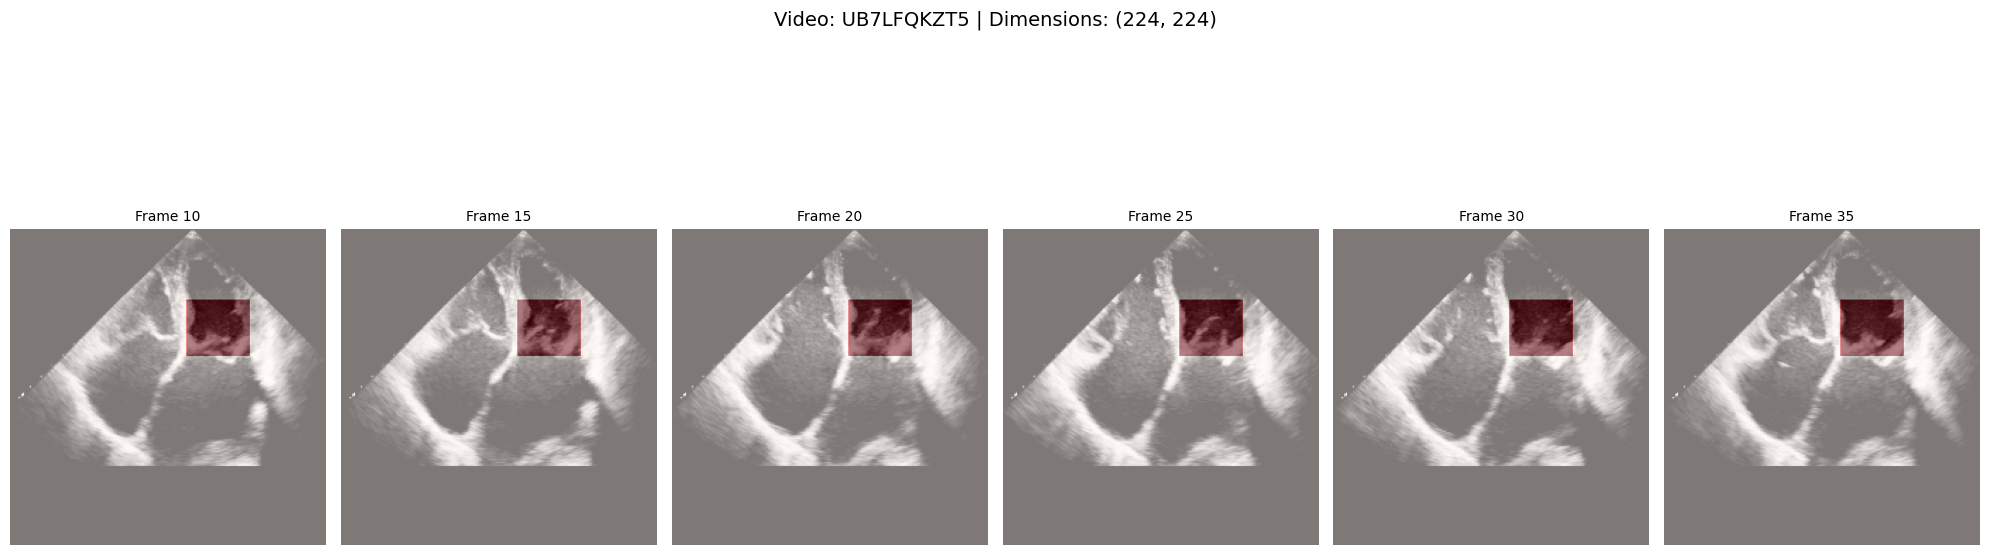

In [15]:
plot_six_frames(test_data, video_index)

In [12]:
for i in range(0, 20):
    print(i, get_box_coordinates(test_data, i))

0 (110, 50, 53, 52)
1 (118, 50, 53, 50)
2 (90, 70, 57, 45)
3 (95, 100, 60, 39)
4 (110, 80, 55, 39)
5 (100, 65, 50, 45)
6 (113, 80, 50, 42)
7 (110, 60, 52, 50)
8 (115, 80, 45, 40)
9 (126, 48, 44, 42)
10 (100, 85, 54, 54)
11 (110, 85, 46, 43)
12 (107, 90, 53, 40)
13 (128, 70, 52, 40)
14 (107, 75, 55, 45)
15 (110, 75, 55, 50)
16 (105, 65, 50, 40)
17 (100, 90, 65, 55)
18 (115, 70, 59, 58)
19 (130, 55, 35, 27)


In [20]:
# Update boxes for all videos
box_parameters = [
    (110, 50, 53, 52),
    (118, 50, 53, 50),
    (90, 70, 57, 45),
    (95, 100, 60, 39),
    (110, 80, 55, 39),
    (100, 65, 50, 45),
    (113, 80, 50, 42),
    (110, 60, 52, 50),
    (115, 80, 45, 40),
    (126, 48, 44, 42),
    (100, 85, 54, 54),
    (110, 85, 46, 43),
    (107, 90, 53, 40),
    (128, 66, 52, 44),
    (107, 75, 55, 45),
    (110, 75, 55, 50),
    (105, 65, 50, 40),
    (100, 90, 65, 55),
    (115, 70, 59, 58),
    (125, 46, 45, 49)
]

# Apply the move_box function for all boxes
for video_index, (x, y, width, height) in enumerate(box_parameters):
    test_data = move_box(test_data, video_index=video_index, x=x, y=y, width=width, height=height)

np.save('./out/preprocessed6bis/test_processed_with_boxes_MANUAL.npy', test_data)

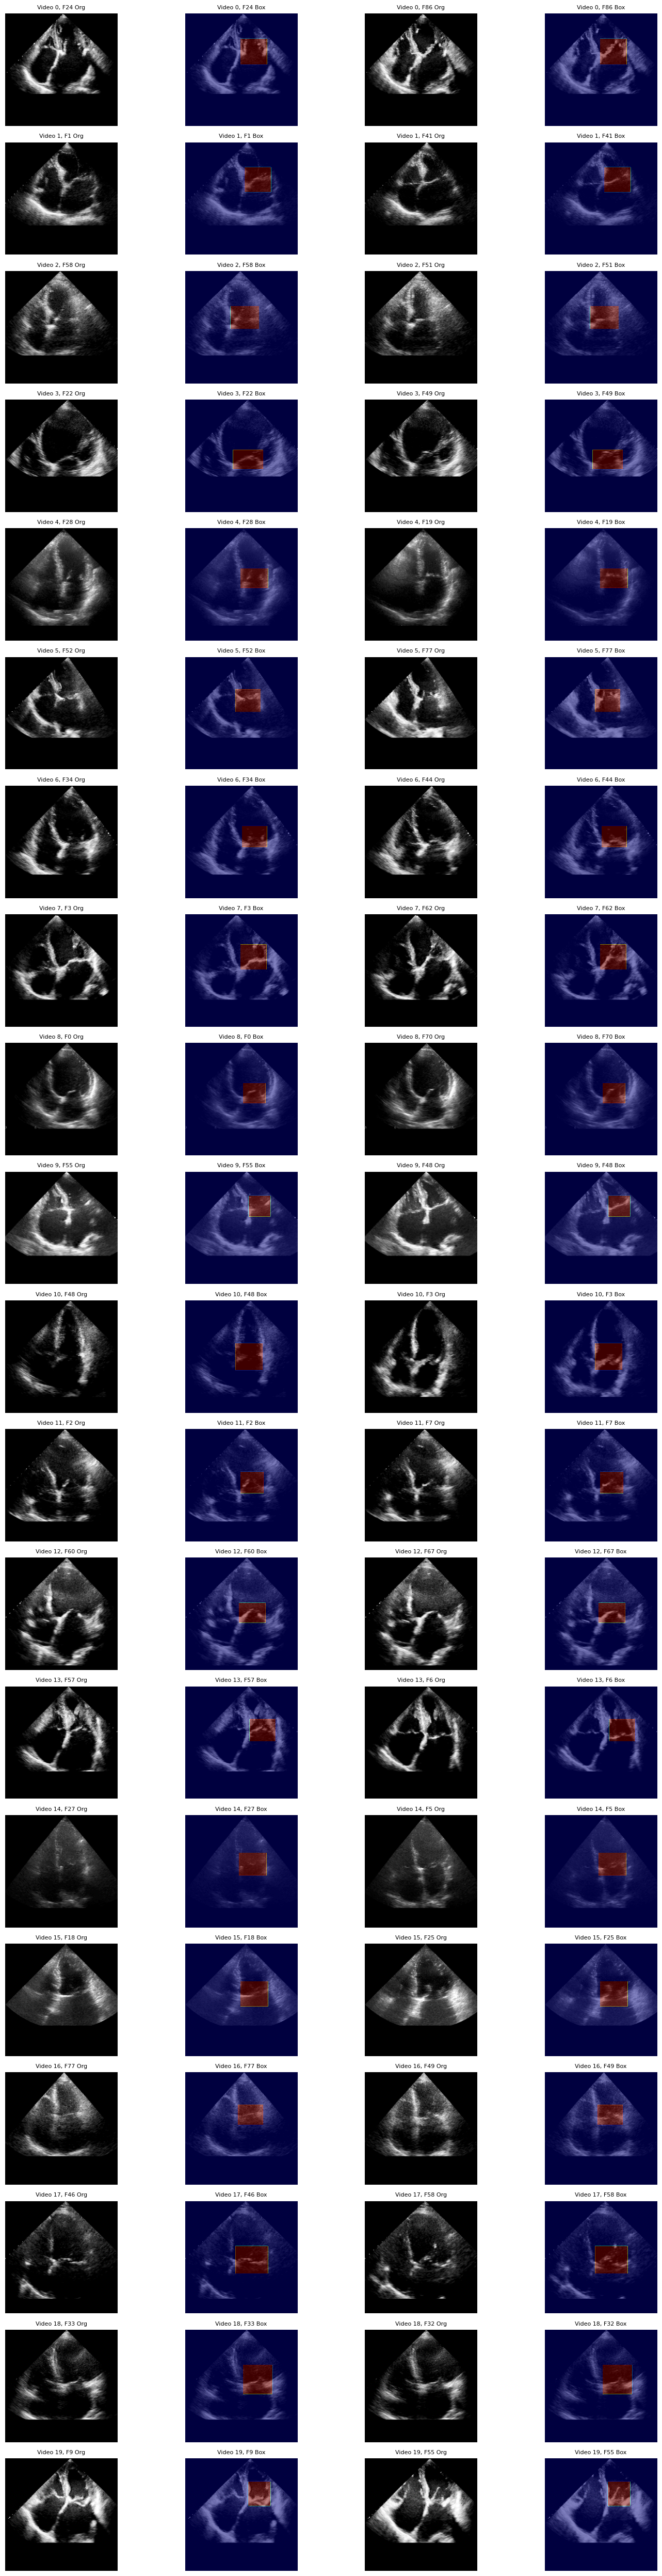

In [21]:
plot_test_data_all_with_boxes(test_data)

### Store original shape for later postprocessing

In [28]:
# Load Original Test Data for Dimensions
with (gzip.open('data/test.pkl', 'rb') as f):
    original_test_data = pickle.load(f)

# Store original shapes
original_shapes = {patient['name']: patient['video'].shape[:-1] for patient in original_test_data}
print(f"Loaded original shapes for {len(original_shapes)} patients.")

print(original_test_data[0]['video'].shape)
print(original_shapes)

Loaded original shapes for 20 patients.
(586, 821, 103)
{'E9AHVWGBUF': (586, 821), 'H7G0BX4HFV': (587, 791), '8FKMSXTPSJ': (583, 777), 'JANFS05F33': (582, 851), 'O7WUJ71C15': (732, 845), '1XHV0Q88M5': (583, 809), '401JD35E1A': (582, 737), 'VODEK84RH4': (587, 775), 'ONA22CCCFQ': (730, 956), '7UXIXUBK2G': (587, 781), 'ESY800XYMN': (583, 681), '571G03ZYDA': (587, 713), 'QZA3WA0E2X': (587, 612), 'JQX264DTZ0': (587, 773), 'TYM0IJW004': (707, 855), 'CD4RIAOCHG': (731, 1007), 'D271IBSMUW': (583, 780), '0MVRNDWR1G': (583, 670), '1QSFD8ORNM': (594, 745), 'UB7LFQKZT5': (583, 779)}


### Get the latest fine-tuned model (best one)

In [22]:
# Find the latest fine-tuned model checkpoint
def find_latest_fine_tuned_model(checkpoint_dir):
    best_model = None
    best_epoch = -1

    for file_name in os.listdir(checkpoint_dir):
        match = re.match(r'best_model_fine_tune_epoch_(\d+)\.pth', file_name)
        if match:
            epoch = int(match.group(1))
            if epoch > best_epoch:
                best_epoch = epoch
                best_model = os.path.join(checkpoint_dir, file_name)

    if best_model:
        print(f"Using best fine-tuned model: {best_model}")
    else:
        raise FileNotFoundError("No fine-tuned model found.")

    return best_model

In [23]:
model_path = find_latest_fine_tuned_model(checkpoint_dir)

Using best fine-tuned model: ./out/checkpoints6bis_new_new/best_model_fine_tune_epoch_107.pth


### Predict Masks on Test Data

In [24]:
def predict_masks_on(test_data, model_path, device, box_name='guessed_box'):
    model = UNet(n_classes=1, n_channels=2, bilinear=False).to(device)  # Model with 2 input channels
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.eval()

    for patient in tqdm(test_data, desc="Predicting masks on test data"):
        video_frames = patient['video']  # Shape: (frames, height, width)
        box = patient[box_name]  # Box mask (H, W)

        predicted_masks = []
        with torch.no_grad():
            for frame_idx in range(video_frames.shape[0]):  # Iterate over frames
                video_frame = video_frames[frame_idx]
                X = np.stack([video_frame, box], axis=0)  # Combine frame and box as 2 channels
                frame_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0).to(device)

                pred_mask = model(frame_tensor)
                pred_mask = (pred_mask > 0.5).float().cpu().numpy().squeeze()  # Binarize prediction

                # Debugging: Count True and False values in the current frame
                #print(f"Frame {frame_idx}:")
                #print(f"  Number of 1s: {np.sum(pred_mask == 1)}")
                #print(f"  Number of 0s: {np.sum(pred_mask == 0)}")

                predicted_masks.append(pred_mask)

        # Add predicted masks to the patient dictionary
        patient['predicted_mask'] = np.array(predicted_masks)

In [25]:
predict_masks_on(test_data, model_path, device, box_name='guessed_box')

Predicting masks on test data: 100%|██████████| 20/20 [00:44<00:00,  2.24s/it]


In [26]:
test_data2 = test_data.copy()

In [29]:
def rescale_image_with_cv2(image, target_shape, is_mask=False):
    original_height, original_width = target_shape
    max_dim = max(original_height, original_width)

    # Choose interpolation method
    interpolation = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR

    # Step 1: Resize back to padded square size
    restored_square = cv2.resize(image, (max_dim, max_dim), interpolation=interpolation)

    # Step 2: Crop to original dimensions
    restored_image = restored_square[:original_height, :original_width]

    return restored_image


# Restore all data fields to original dimensions
for patient in test_data:
    name = patient['name']
    original_shape = original_shapes[name]  # Get original shape (height, width)

    # print(f"Restoring patient {name}: original_shape={original_shape}")

    # Restore video frames
    restored_video = [rescale_image_with_cv2(frame, original_shape) for frame in patient['video']]
    patient['video'] = np.array(restored_video)

    # Restore box
    if patient['guessed_box'].dtype == bool:
        patient['guessed_box'] = patient['guessed_box'].astype(np.uint8) * 255
    patient['guessed_box'] = rescale_image_with_cv2(patient['guessed_box'], original_shape)

    # Restore predicted masks
    restored_masks = [rescale_image_with_cv2(mask, original_shape, is_mask=True) for mask in patient['predicted_mask']]
    patient['predicted_mask'] = np.array(restored_masks)

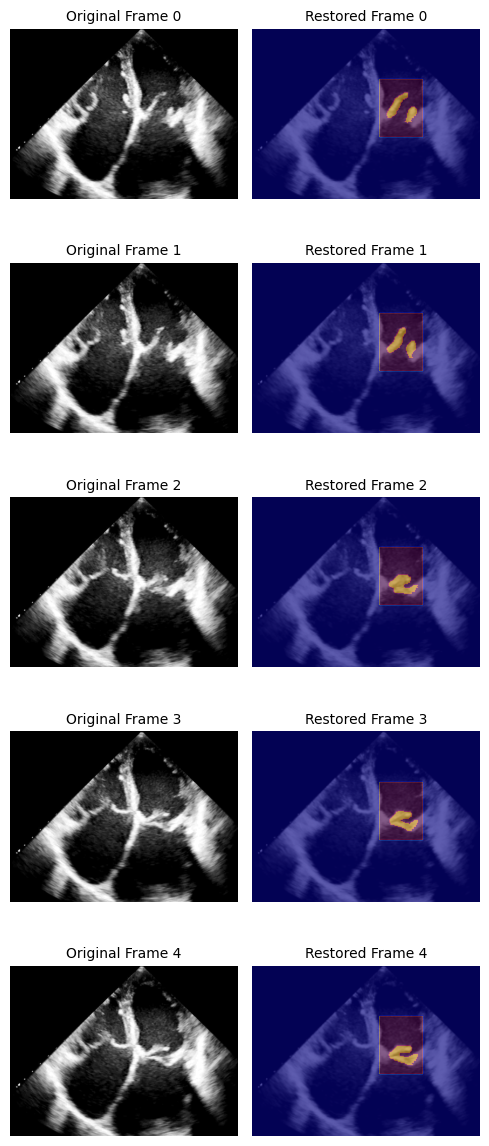

In [85]:
import matplotlib.pyplot as plt

# Create a figure with subplots for side-by-side comparison
fig, axes = plt.subplots(5, 2, figsize=(5, 12))  # 5 rows, 2 columns for comparison

for i, frame_idx in enumerate(range(5)):
    # Extract frames from both datasets
    original_frame = original_test_data[19]['video'][:, :, frame_idx]  # Original frame
    restored_frame = test_data[19]['video'][frame_idx]  # Restored frame
    predicted_mask = test_data[19]['predicted_mask'][frame_idx]  # Overlay mask
    true_box = test_data[19]['guessed_box']  # Overlay box

    # Plot original frame
    axes[i, 0].imshow(original_frame, cmap='gray')
    axes[i, 0].set_title(f"Original Frame {frame_idx}", fontsize=10)
    axes[i, 0].axis('off')

    # Plot restored frame with overlays
    axes[i, 1].imshow(restored_frame, cmap='gray')
    axes[i, 1].imshow(predicted_mask, cmap='plasma', alpha=0.5)
    axes[i, 1].imshow(true_box, cmap='jet', alpha=0.3)
    axes[i, 1].set_title(f"Restored Frame {frame_idx}", fontsize=10)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

### Visualize Predictions

In [30]:
# Plot the first 5 random frames for 10 random videos with shorter titles
def plot_test_inference_results_with_masks(test_data, num_videos=10, frames_per_video=5, box_name='guessed_box'):
    fig, axes = plt.subplots(num_videos, frames_per_video * 2, figsize=(15, 5 * num_videos / 2))

    for i in range(num_videos):
        # Randomly pick a patient
        patient_idx = i  #random.randint(0, len(test_data) - 1)
        video_frames = test_data[patient_idx]['video']
        true_box = test_data[patient_idx][box_name]  # Ground-truth box
        predicted_masks = test_data[patient_idx]['predicted_mask']  # Predicted masks

        # Randomly select 5 frames from the video
        frame_indices = random.sample(range(video_frames.shape[0]), frames_per_video)

        for j, frame_idx in enumerate(frame_indices):
            # Extract the frame data
            video_frame = video_frames[frame_idx]
            predicted_mask = predicted_masks[frame_idx]

            ## Plot Original Frame
            #axes[i, j * 2].imshow(video_frame, cmap='gray')
            #axes[i, j * 2].set_title(f"F{frame_idx} Org", fontsize=8)
            #axes[i, j * 2].axis('off')

            # Plot Frame with Guessed Mask
            axes[i, j * 2].imshow(video_frame, cmap='gray')
            axes[i, j * 2].imshow(predicted_mask, cmap='plasma', alpha=0.5)
            axes[i, j * 2].set_title(f"F{frame_idx} Mask", fontsize=8)
            axes[i, j * 2].axis('off')

            # Plot Frame with Guessed Box
            axes[i, j * 2 + 1].imshow(video_frame, cmap='gray')
            axes[i, j * 2 + 1].imshow(true_box, cmap='jet', alpha=0.5)
            axes[i, j * 2 + 1].set_title(f"F{frame_idx} Box", fontsize=8)
            axes[i, j * 2 + 1].axis('off')

            # Add title for the first row video number
            if j == 0:
                axes[i, j * 3].set_title(f"Video {patient_idx}", fontsize=10)

    plt.tight_layout()
    plt.show()


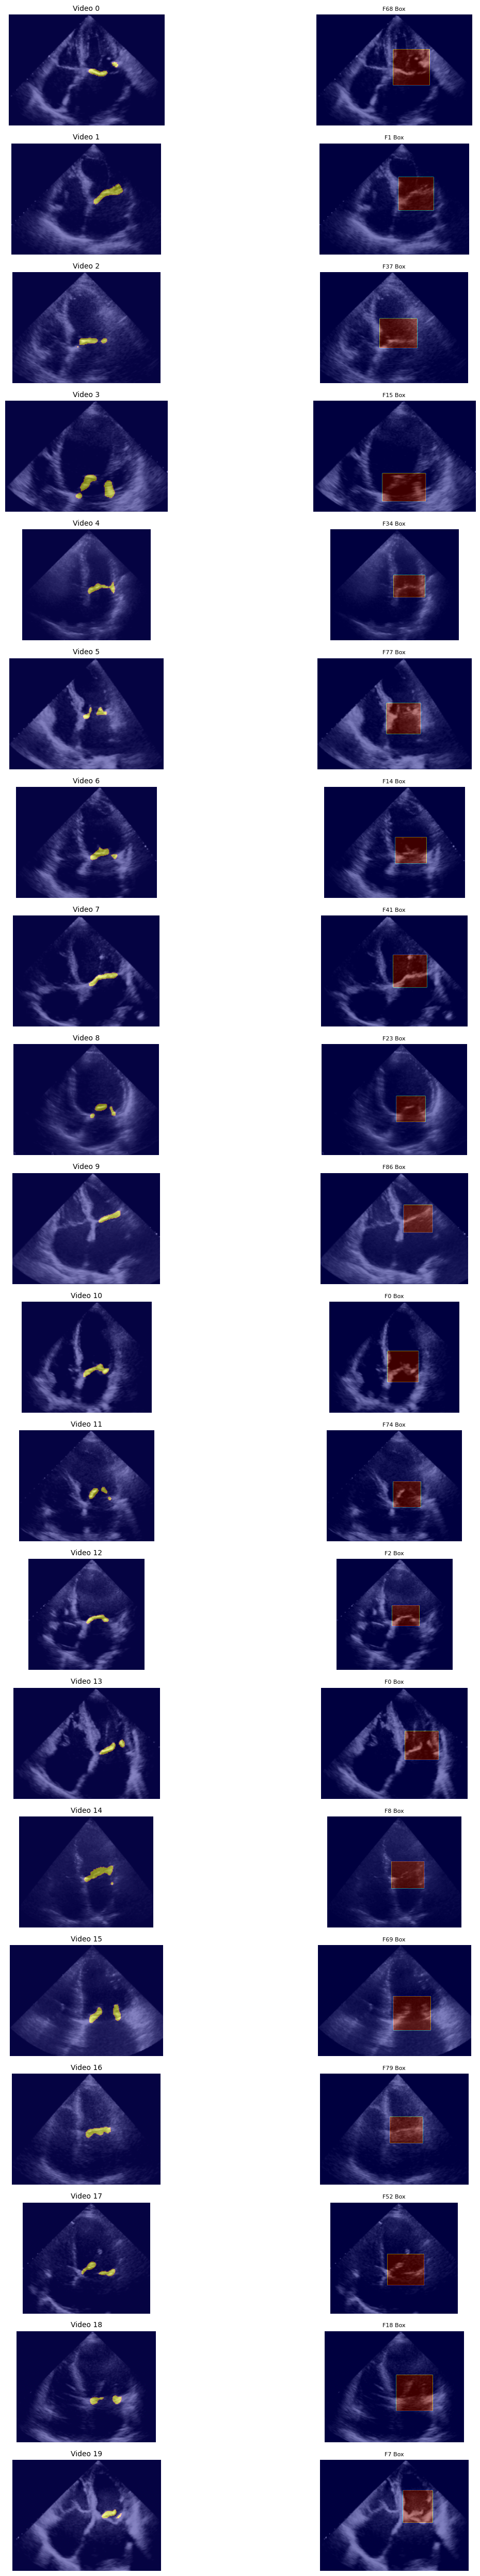

In [31]:
plot_test_inference_results_with_masks(test_data, num_videos=test_data.shape[0], frames_per_video=1)

### Create Submission File

In [32]:
test_data[0]["predicted_mask"].shape

(103, 586, 821)

In [33]:
def get_sequences(arr):
    """
    Extracts contiguous sequences of 1s from a flattened array for submission format.
    Returns start indices and lengths of the sequences.
    """
    indices = np.where(arr == 1)[0]  # Indices where the value is 1
    if len(indices) == 0:
        return [0], [0]  # No sequences found

    start_indices = [indices[0]]  # Start with the first index
    lengths = []

    # Iterate through indices to find sequences
    for i in range(1, len(indices)):
        if indices[i] != indices[i - 1] + 1:  # Gap detected
            lengths.append(indices[i - 1] - start_indices[-1] + 1)
            start_indices.append(indices[i])

    # Append the last sequence length
    lengths.append(indices[-1] - start_indices[-1] + 1)

    return start_indices, lengths

In [34]:
def create_submission_file(data, output_path, mask_key='predicted_mask'):
    ids = []
    values = []

    for patient in tqdm(data, desc="Formatting predictions"):
        name = patient['name']  # Video name
        masks = patient[mask_key]  # Predicted masks for the video

        # Flatten the entire video mask into a 1D array
        masks = masks.transpose(1, 2, 0)
        flat_mask = masks.flatten()

        # Find contiguous regions of 1s
        indices, lengths = get_sequences(flat_mask)

        # Create submission rows for each region
        for i, (start_idx, length) in enumerate(zip(indices, lengths)):
            ids.append(f"{name}_{i}")
            values.append([int(start_idx), int(length)])

    # Create DataFrame and save
    submission_df = pd.DataFrame({
        "id": ids,
        "value": values
    })

    submission_df.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")


In [35]:
test_submission_path = "./out/test_fine_tune_epoch_107_upgrade_again_auto.csv"
create_submission_file(test_data, test_submission_path, mask_key='predicted_mask')

Formatting predictions: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


Submission saved to ./out/test_fine_tune_epoch_107_upgrade_again_auto.csv


### ON TRAIN DATA COMPARISON

In [236]:
# Predict masks on expert data
preprocessed_expert_data = np.load('./out/preprocessed6bis/preprocessed_expert_data.npy', allow_pickle=True)
predict_masks_on(preprocessed_expert_data, model_path, device, box_name='box')

# Step 4: Export two submissions
# Submission 1: True masks
for patient in preprocessed_expert_data:
    patient['true_mask'] = patient['box']  # Assuming true masks are stored in 'box'

#true_submission_path = "./out/true_masks_submission_expert.csv"
#create_submission_file(preprocessed_expert_data, true_submission_path, mask_key='mask')
#
## Submission 2: Predicted masks
#predicted_submission_path = "./out/predicted_masks_submission_expert.csv"
#create_submission_file(preprocessed_expert_data, predicted_submission_path, mask_key='predicted_mask')

Predicting masks on test data: 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]


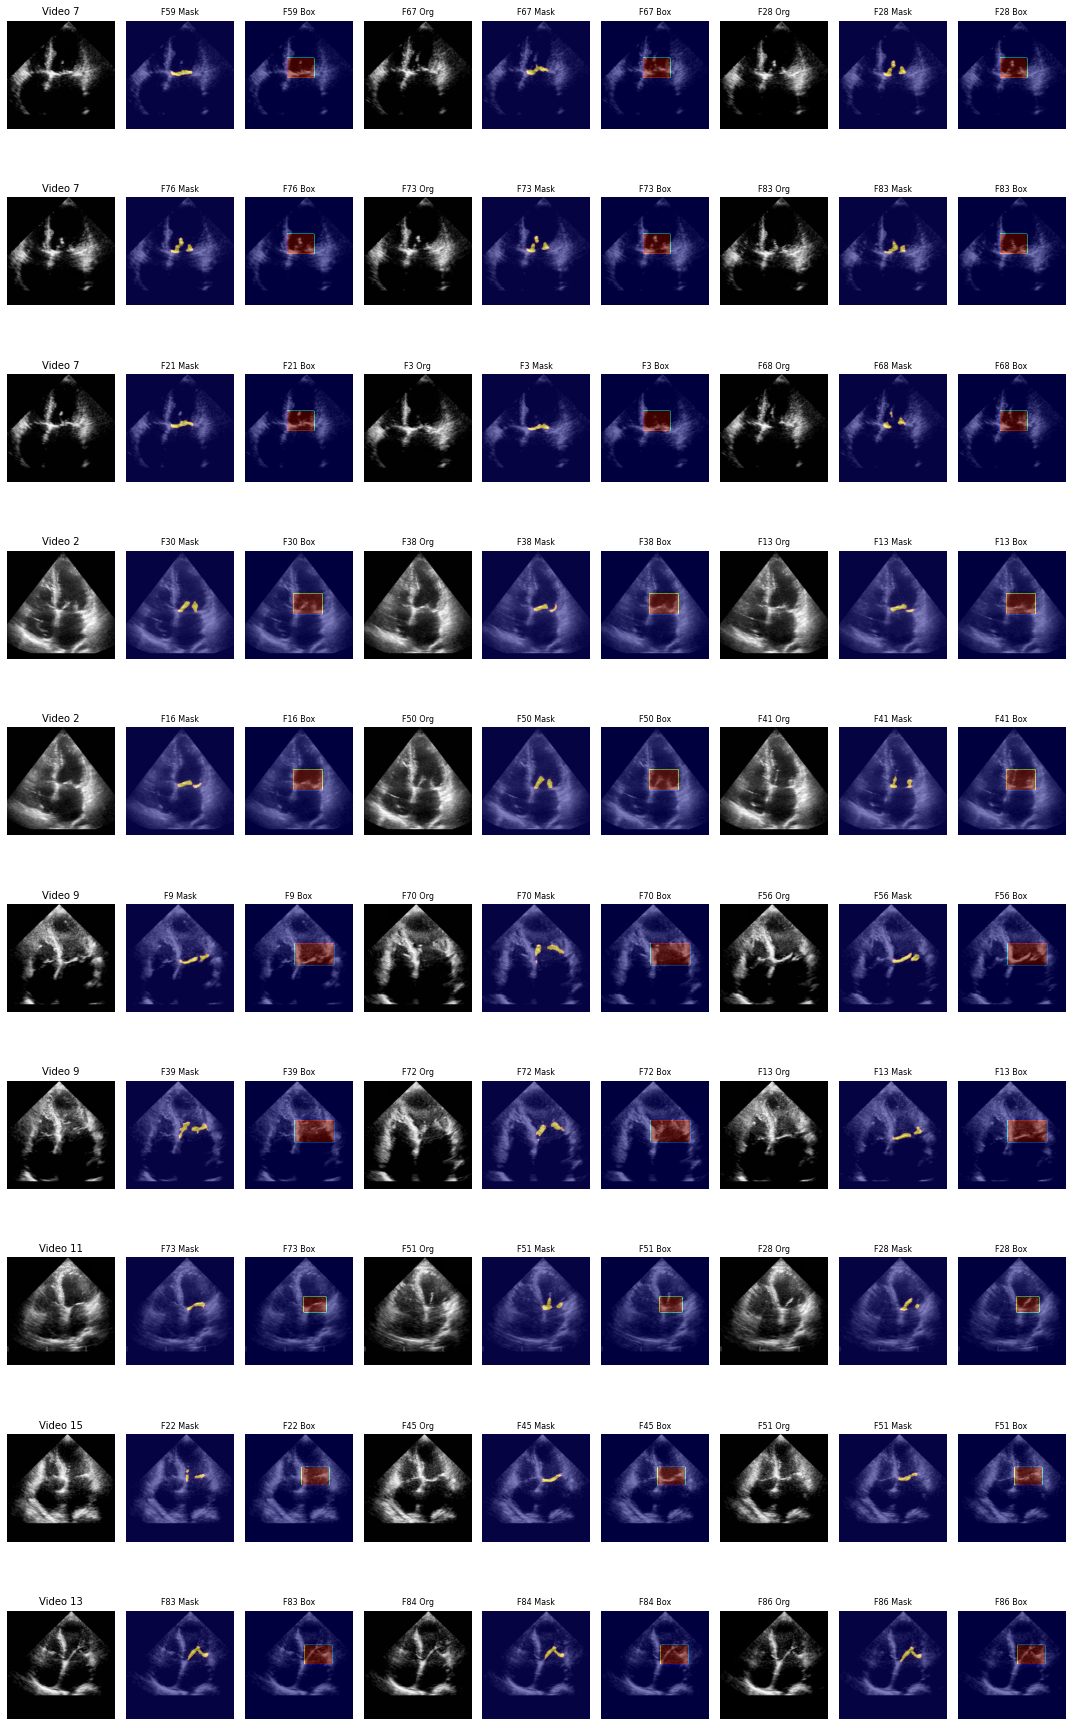

In [237]:
plot_test_inference_results_with_masks(preprocessed_expert_data, num_videos=10, frames_per_video=3, box_name='box')